# Hybrid hotel recommendation system

## Environment

Environment required

- Python (>= 3.5)
- NumPy (>= 1.11.0)
- SciPy (>= 0.17.0)
- joblib (>= 0.11)

- For Light gbm VC runtime is needed if Visual Studio (2015 or newer) is not installed.Available in below link
https://support.microsoft.com/en-us/help/2977003/the-latest-supported-visual-c-downloads

- 32-bit Python is not supported by light gbm and catboost. Please install 64-bit version.

## Libraries

Install the below libraries if not yet installed

In [116]:
#pip install -U numpy scipy matplotlib ipython jupyter pandas sympy nose
#pip install -U seaborn
#pip install -U scikit-learn
#pip install -U langdetect
#pip install -U geopy
#pip install -U textblob
#pip install -U catboost
#pip install -U lightgbm
#pip install -U xgboost

In [327]:
#import libraries
import time
from datetime import datetime
import os
import pandas as pd
import numpy as np
import random
from collections import Counter

import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn')
plt.rcParams.update({'figure.max_open_warning': 0})
import seaborn as sns
sns.set_style('whitegrid')

from catboost import CatBoostRegressor
import lightgbm as lgb
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import Pipeline

import re
from sklearn.feature_extraction.text import TfidfVectorizer
from surprise import SVD
from langdetect import detect # python language detection
import nltk
from textblob import TextBlob
from scipy import sparse
from scipy.sparse import csr_matrix

from geopy.distance import great_circle

## Execution note:

To execute all cells it may take around 30 minutes.To just run the models follow below steps

Run all the cells for the first time . From then on, run only below cells

- Load merge data
- Split data into train and test
- Then directly go to "Machine learning models" section
- Run all the proceeding cells

This will only take few minutes 

## Directory path

Set the directory path where listings and reviews files are located

Create following folders in the corresponding directory

- saved_csv
- pickels
- result

In [328]:
#Set the path of the Data set for easy access
dir_path = r"D:\Project\hybrid hotel recommendation system\data_set\berlin_airbnb_data"

## Load data

In [329]:
#Detailed hotel listings
listings_orig = pd.read_csv(os.path.join(dir_path,"listings_summary.csv"))

#Detailed hotel reviews
reviews_orig = pd.read_csv(os.path.join(dir_path,"reviews_summary.csv"))


## Data preprocessing

### Listings 

In [330]:
# checking shape
print("The dataset has {} rows and {} columns.".format(*listings_orig.shape))

# ... and duplicates
print("It contains {} duplicates.".format(listings_orig.duplicated().sum()))

The dataset has 22552 rows and 96 columns.
It contains 0 duplicates.


#### Deciding which columns to work with

In [331]:
# define the columns we want to keep
columns_to_keep = ['id','name', 'space', 'description', 'neighbourhood_group_cleansed', 
                   'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',  
                   'bedrooms', 'bed_type', 'amenities', 'square_feet', 'price', 'cleaning_fee', 
                   'security_deposit', 'extra_people', 'guests_included', 'minimum_nights',  
                   'instant_bookable', 'is_business_travel_ready', 'cancellation_policy','host_is_superhost','number_of_reviews']

In [332]:
# It is used to skip the warning ''SettingWithCopyWarning''.. 
pd.options.mode.chained_assignment = None  # default='warn'

listings_df = listings_orig[columns_to_keep]
listings_df.rename(columns={'id':'listing_id'}, inplace=True)
print("The dataset has {} rows and {} columns - after dropping irrelevant columns.".format(*listings_df.shape))

The dataset has 22552 rows and 26 columns - after dropping irrelevant columns.


#### Cleaning Price Columns

In [333]:
#check NaN
print(listings_df.price.isna().sum())
print(listings_df.cleaning_fee.isna().sum())
print(listings_df.security_deposit.isna().sum())
print(listings_df.extra_people.isna().sum())

0
7146
9361
0


In [334]:
#fill NaN for cleaning fee and security deposit
listings_df.cleaning_fee.fillna('$0.00', inplace=True)
listings_df.security_deposit.fillna('$0.00', inplace=True)

In [335]:
# clean up the columns (by method chaining)
listings_df.price = listings_df.price.str.replace('$', '').str.replace(',', '').astype(float)
listings_df.cleaning_fee = listings_df.cleaning_fee.str.replace('$', '').str.replace(',', '').astype(float)
listings_df.security_deposit = listings_df.security_deposit.str.replace('$', '').str.replace(',', '').astype(float)
listings_df.extra_people = listings_df.extra_people.str.replace('$', '').str.replace(',', '').astype(float)

#### Investigate price

In [336]:
listings_df.price.describe()

count    22552.000000
mean        67.143668
std        220.266210
min          0.000000
25%         30.000000
50%         45.000000
75%         70.000000
max       9000.000000
Name: price, dtype: float64

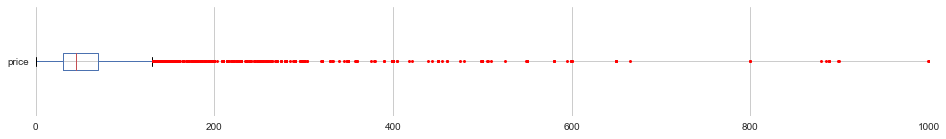

In [337]:
red_square = dict(markerfacecolor='r', markeredgecolor='r', marker='.')
listings_df['price'].plot(kind='box', xlim=(0, 1000), vert=False, flierprops=red_square, figsize=(16,2));

75% of the apartments charge up to 68 - but the maximum value is 9000. Let's decide on a limit of 400, after which the outliers seem to "fringe", and drop all records that charge more than that. Oddly enough, we have prices set to zero. So let's drop those records, too:

In [338]:
listings_df.drop(listings_df[ (listings_df.price > 400) | (listings_df.price == 0) ].index, axis=0, inplace=True)

In [339]:
listings_df['price'].describe()

count    22441.000000
mean        57.584377
std         42.162006
min          1.000000
25%         30.000000
50%         45.000000
75%         70.000000
max        400.000000
Name: price, dtype: float64

In [340]:
print("The dataset has {} rows and {} columns - after being price-wise preprocessed.".format(*listings_df.shape))

The dataset has 22441 rows and 26 columns - after being price-wise preprocessed.


#### Dealing with Missing Values

In [341]:
listings_df.isna().sum()

listing_id                          0
name                               58
space                            8503
description                       202
neighbourhood_group_cleansed        0
latitude                            0
longitude                           0
property_type                       0
room_type                           0
accommodates                        0
bathrooms                          32
bedrooms                           18
bed_type                            0
amenities                           0
square_feet                     21996
price                               0
cleaning_fee                        0
security_deposit                    0
extra_people                        0
guests_included                     0
minimum_nights                      0
instant_bookable                    0
is_business_travel_ready            0
cancellation_policy                 0
host_is_superhost                  25
number_of_reviews                   0
dtype: int64

In [342]:
# drop columns with too many Nan's
listings_df.drop(columns=['square_feet', 'space','description'], inplace=True)

In [343]:
# drop rows with NaN's in bathrooms and bedrooms
listings_df.dropna(subset=['bathrooms', 'bedrooms'], inplace=True)

In [344]:
listings_df.host_is_superhost.fillna('f', inplace = True)

In [345]:
listings_df.isna().sum()

listing_id                       0
name                            57
neighbourhood_group_cleansed     0
latitude                         0
longitude                        0
property_type                    0
room_type                        0
accommodates                     0
bathrooms                        0
bedrooms                         0
bed_type                         0
amenities                        0
price                            0
cleaning_fee                     0
security_deposit                 0
extra_people                     0
guests_included                  0
minimum_nights                   0
instant_bookable                 0
is_business_travel_ready         0
cancellation_policy              0
host_is_superhost                0
number_of_reviews                0
dtype: int64

In [346]:
print("The dataset has {} rows and {} columns - after having dealt with missing values.".format(*listings_df.shape))

The dataset has 22391 rows and 23 columns - after having dealt with missing values.


#### Feature engineering

Feature Engineering 1: Distance to Centroid of Berlin

calculate each accommodation's distance to the so-called centroid of Berlin instead of just relying on the neighbourhoods or areas.

In [347]:
def distance_to_mid(lat, lon):
    berlin_centre = (52.5027778, 13.404166666666667)
    accommodation = (lat, lon)
    return great_circle(berlin_centre, accommodation).km

In [348]:
listings_df['distance'] = listings_df.apply(lambda x: distance_to_mid(x.latitude, x.longitude), axis=1)

In [349]:
listings_df.head(2)

,listing_id,name,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,...,security_deposit,extra_people,guests_included,minimum_nights,instant_bookable,is_business_travel_ready,cancellation_policy,host_is_superhost,number_of_reviews,distance
0,2015,Berlin-Mitte Value! Quiet courtyard/very central,Mitte,52.534537,13.402557,Guesthouse,Entire home/apt,3,1.0,1.0,...,200.0,28.0,1,4,f,f,strict_14_with_grace_period,t,118,3.533182
1,2695,Prenzlauer Berg close to Mauerpark,Pankow,52.548513,13.404553,Apartment,Private room,2,1.0,1.0,...,0.0,0.0,1,2,f,f,flexible,f,6,5.085573


Feature Engineering 2: Lodging Amenities

In [350]:
results = Counter()
listings_df['amenities'].str.strip('{}')\
               .str.replace('"', '')\
               .str.lstrip('\"')\
               .str.rstrip('\"')\
               .str.split(',')\
               .apply(results.update)
results.most_common(10)

[('Wifi', 21372),
 ('Kitchen', 21216),
 ('Heating', 21073),
 ('Essentials', 20211),
 ('Washer', 18395),
 ('Hair dryer', 14793),
 ('Laptop friendly workspace', 14374),
 ('Hangers', 13814),
 ('Iron', 11121),
 ('Shampoo', 10572)]

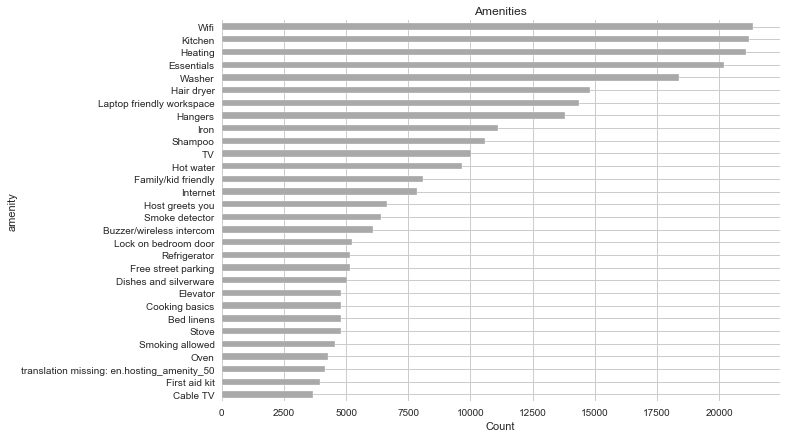

In [351]:
# create a new dataframe
sub_df = pd.DataFrame(results.most_common(30), columns=['amenity', 'count'])
# plot the Top 20
sub_df.sort_values(by=['count'], ascending=True).plot(kind='barh', x='amenity', y='count',  
                                                      figsize=(10,7), legend=False, color='darkgrey',
                                                      title='Amenities')
plt.xlabel('Count');

Let's add columns with amenities that are somewhat unique and not offered by all hosts:

- a laptop-friendly workspace
- a TV
- kid friendly accommodation
- smoker friendly and
- being greeted by the host

In [352]:
listings_df['Laptop_friendly_workspace'] = listings_df['amenities'].str.contains('Laptop friendly workspace')
listings_df['TV'] = listings_df['amenities'].str.contains('TV')
listings_df['Family_kid_friendly'] = listings_df['amenities'].str.contains('Family/kid friendly')
listings_df['Host_greets_you'] = listings_df['amenities'].str.contains('Host greets you')
listings_df['Smoking_allowed'] = listings_df['amenities'].str.contains('Smoking allowed')

#Drop amenities
listings_df.drop(['amenities'], axis=1, inplace=True)

Drop unuseful columns

In [353]:
listings_df.drop(['latitude', 'longitude', 'neighbourhood_group_cleansed', 'property_type'], axis=1, inplace=True)

Now let's convert all string columns into categorical ones:

In [354]:
for col in ['host_is_superhost','room_type', 'bed_type', 'instant_bookable', 
            'is_business_travel_ready', 'cancellation_policy']:
    listings_df[col] = listings_df[col].astype('category')

In [355]:
num_feats = listings_df.select_dtypes(include=['float64', 'int64', 'bool']).copy()

keep_feats = listings_df[['name']]
# one-hot encoding of categorical features
cat_feats = listings_df.select_dtypes(include=['category']).copy()
cat_feats = pd.get_dummies(cat_feats)

In [356]:
listings_df = pd.concat([keep_feats,num_feats, cat_feats], axis=1)

In [357]:
listings_df.head(2)

,name,listing_id,accommodates,bathrooms,bedrooms,price,cleaning_fee,security_deposit,extra_people,guests_included,...,instant_bookable_f,instant_bookable_t,is_business_travel_ready_f,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict_14_with_grace_period,cancellation_policy_super_strict_30,cancellation_policy_super_strict_60,host_is_superhost_f,host_is_superhost_t
0,Berlin-Mitte Value! Quiet courtyard/very central,2015,3,1.0,1.0,60.0,30.0,200.0,28.0,1,...,1,0,1,0,0,1,0,0,0,1
1,Prenzlauer Berg close to Mauerpark,2695,2,1.0,1.0,17.0,0.0,0.0,0.0,1,...,1,0,1,1,0,0,0,0,1,0


Save the finalised listings dataframe to a pickle file in order to avoid the long runtime

In [358]:
#Run for the first time and then comment the below 2 lines 
listings_df.to_csv(os.path.join(dir_path,"saved_csv/listings_df.csv"))
listings_df.to_pickle(os.path.join(dir_path,"pickels/listings_df"))

#Load from pickle
listings_df = pd.read_pickle(os.path.join(dir_path,"pickels/listings_df"))

### Reviews

In [359]:
#Columns to keep
col_keep = ['listing_id','reviewer_id','reviewer_name','date','comments']

In [360]:
reviews_df = reviews_orig [col_keep]

In [361]:
# checking shape
print("The dataset has {} rows and {} columns - after dropping irrelevant columns.".format(*reviews_df.shape))

The dataset has 401963 rows and 5 columns - after dropping irrelevant columns.


#### Dealing with Missing Values

In [362]:
print(reviews_df.isna().sum())

listing_id         0
reviewer_id        0
reviewer_name      0
date               0
comments         496
dtype: int64


In [363]:
reviews_df['comments'] =  reviews_df['comments'].fillna('')

print("The dataset has {} rows and {} columns.".format(*reviews_df.shape))

The dataset has 401963 rows and 5 columns.


In [364]:
print(reviews_df.isna().sum())

listing_id       0
reviewer_id      0
reviewer_name    0
date             0
comments         0
dtype: int64


#### Language Detection

Language detection takes around 20-25 mins of run time. Run only when necessary

In [365]:
#function that detects the language
def language_detection(text):
    try:
        return detect(text)
    except:
        return None

In [366]:
%%time
reviews_df['language'] = reviews_df['comments'].apply(language_detection)


Wall time: 22min 50s


Save the reviews data frame after language detection to a pickle file in order to avoid the long runtime

In [370]:
#write the dataframe to a pickle file in order to avoid the long runtime
reviews_df.to_csv(os.path.join(dir_path,"saved_csv/review_data_lang_detect.csv"))
reviews_df.to_pickle(os.path.join(dir_path,"pickels/review_data_lang_detect"))

#Load from pickle
reviews_df = pd.read_pickle(os.path.join(dir_path,"pickels/review_data_lang_detect"))

In [371]:
#Sample review data
reviews_df.head()

,listing_id,reviewer_id,reviewer_name,date,comments,language
0,2015,7178145,Rahel,2016-04-11,Mein Freund und ich hatten gute gemütliche vie...,de
1,2015,41944715,Hannah,2016-04-15,Jan was very friendly and welcoming host! The ...,en
2,2015,30048708,Victor,2016-04-26,Un appartement tres bien situé dans un quartie...,fr
3,2015,63697857,Judy,2016-05-10,"It is really nice area, food, park, transport ...",en
4,2015,10414887,Romina,2016-05-14,"Buena ubicación, el departamento no está orden...",es


In [372]:
#Most frequently used language in comments
reviews_df.language.value_counts().head(10)

en    271866
de     77154
fr     16864
es     12176
it      4860
nl      3900
ru      2308
ko      1634
pt      1397
da      1363
Name: language, dtype: int64

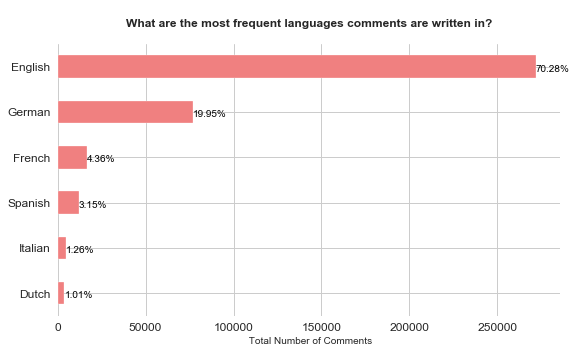

In [373]:
# visualizing the comments' languages
ax = reviews_df.language.value_counts().head(6).plot(kind='barh', figsize=(9,5), color="lightcoral", 
                                             fontsize=12);

ax.set_title("\nWhat are the most frequent languages comments are written in?\n", 
             fontsize=12, fontweight='bold')
ax.set_xlabel(" Total Number of Comments", fontsize=10)
ax.set_yticklabels(['English', 'German', 'French', 'Spanish', 'Italian', 'Dutch'])

# create a list to collect the plt.patches data
totals = []
# find the ind. values and append to list
for i in ax.patches:
    totals.append(i.get_width())
# get total
total = sum(totals)

# set individual bar labels using above list
for i in ax.patches:
    ax.text(x=i.get_width(), y=i.get_y()+.35, 
            s=str(round((i.get_width()/total)*100, 2))+'%', 
            fontsize=10, color='black')

# invert for largest on top 
ax.invert_yaxis()

In [384]:
# Select english only as it covers
reviews_eng = reviews_df[(reviews_df['language']=='en')]
reviews_de  = reviews_df[(reviews_df['language']=='de')]
reviews_fr  = reviews_df[(reviews_df['language']=='fr')]

#### Calucalte sentimental scores</h4>

We have observed that comments that are not translated to english have performed poorly.This could be because these libraries may have been designed with english as the main language

In [385]:
#Sample non-english comment
print(reviews_df.comments[2])
print()

#Sentiment score
print("Sentiment score for above comment:",TextBlob(reviews_df.comments[2]).sentiment)

#Translate the sentence to english
comment_translate = TextBlob(reviews_df.comments[2]).translate(to="en")
print()
print(comment_translate)

#Calculate sentiment score for the translated comment
print()
print("Sentiment score for above translated comment:",TextBlob(str(comment_translate)).sentiment)

Un appartement tres bien situé dans un quartier historique de l'est tres agréable, le métro est tout proche. Pas de connexion internet ni de télé mais cela nous pousse encore plus a découvrir Berlin. Jan est tres accueillant et nous a donné quelques conseils pour nos visites.

Sentiment score for above comment: Sentiment(polarity=0.0, subjectivity=0.0)

An apartment very well located in a historic district of the east very nice, the metro is nearby. No internet connection or TV but it pushes us even more to discover Berlin. Jan is very welcoming and gave us some tips for our tours.

Sentiment score for above translated comment: Sentiment(polarity=0.33599999999999997, subjectivity=0.42000000000000004)


In [376]:
#Function which translates non english comments to english 
def translate_comment(comment ,lang):
    if lang != "en":
        try:
            return str(TextBlob(comment).translate(to = "en"))
        except:
            return comment
    else:
        return comment
    
#Sample    
translated_comment = translate_comment("Mein Freund und ich hatten","de")
print(translated_comment)

My friend and I had


In [106]:
reviews_df.iloc[16]

listing_id             2015
reviewer_id        79022747
reviewer_name        Helena
date             2016-08-15
comments             great 
language                 ro
Name: 16, dtype: object

Below translation requires active internet connection and many hours to execute.
Execute only if feasible.

We have currently used only english comments - reviews_eng.
If successfully able to run the below cell then replace reviews_eng with reviews_df in proceeding cells

In [ ]:
#reviews_df['comments'] = reviews_df.apply(lambda x:translate_comment(x.comments,x.language),axis =1)
#reviews.head()

Save the translated review dataframe to a pickle file in order to avoid the long runtime

In [44]:
#Run for the first time and then comment the below 2 lines
#reviews_df.to_csv(os.path.join(dir_path,"saved_csv/review_data_translated.csv"))
#reviews_df.to_pickle(os.path.join(dir_path,"pickels/review_data_translated"))

#Load from pickle
#reviews_df = pd.read_pickle(os.path.join(dir_path,"pickels/review_data"))

In [386]:
#Function which rescales from (-1,1)polarity to (1,5) rating system.
def rate_comment(comment):
    #[old min, old max] -> [new min,new max]
    old_min = -1
    old_max = 1
    new_min = 1
    new_max = 5
    
    #formula
    rating = ((new_max - new_min) * (TextBlob(str(comment)).polarity - old_min) )/ (old_max - old_min)  + new_min
    return rating

In [387]:
#Calculate rating from rate_comment scores

# It is used to skip the warning ''SettingWithCopyWarning''.. 
pd.options.mode.chained_assignment = None  # default='warn'

reviews_eng['rating'] = reviews_eng['comments'].apply(lambda x: rate_comment(x))

In [388]:
reviews_eng.drop(['comments','reviewer_name','language'],axis=1, inplace=True)

In [399]:
reviews_eng.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 271794 entries, 1 to 401962
Data columns (total 4 columns):
listing_id     271794 non-null int64
reviewer_id    271794 non-null int64
date           271794 non-null object
rating         271794 non-null float64
dtypes: float64(1), int64(2), object(1)
memory usage: 10.4+ MB


In [400]:
reviews_eng.isna().sum()

listing_id     0
reviewer_id    0
date           0
rating         0
dtype: int64

#### Removing Duplicates

In [401]:
dup_bool = reviews_eng.duplicated(['reviewer_id','listing_id','rating'])
dups = sum(dup_bool) # by considering all columns..( including timestamp)
print("There are {} duplicate rating entries in the data..".format(dups))

There are 0 duplicate rating entries in the data..


In [402]:
#Shape before duplicate removal
reviews_eng.shape

(271794, 4)

In [403]:
reviews_eng = reviews_eng.drop_duplicates(subset=['reviewer_id','listing_id','rating'])

In [404]:
#shape after duplicate removal
reviews_eng.shape

(271794, 4)

Save the finalised reviews dataframe to a pickle file in order to avoid the long runtime

In [405]:
#Run for the first time and then comment the below 2 lines
reviews_eng.to_csv(os.path.join(dir_path,"saved_csv/review_data_final.csv"))
reviews_eng.to_pickle(os.path.join(dir_path,"pickels/review_data_final"))

#Load from pickle
reviews_df_final = pd.read_pickle(os.path.join(dir_path,"pickels/review_data_final"))

In [406]:
reviews_df_final.head(2)

,listing_id,reviewer_id,date,rating
1,2015,41944715,2016-04-15,4.35375
3,2015,63697857,2016-05-10,4.60000


### Merge listings and reviews

In [407]:
merged_data = pd.merge(listings_df,reviews_df_final,on = 'listing_id',how='inner')
merged_data.head(2)

,name,listing_id,accommodates,bathrooms,bedrooms,price,cleaning_fee,security_deposit,extra_people,guests_included,...,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict_14_with_grace_period,cancellation_policy_super_strict_30,cancellation_policy_super_strict_60,host_is_superhost_f,host_is_superhost_t,reviewer_id,date,rating
0,Berlin-Mitte Value! Quiet courtyard/very central,2015,3,1.0,1.0,60.0,30.0,200.0,28.0,1,...,0,0,1,0,0,0,1,41944715,2016-04-15,4.35375
1,Berlin-Mitte Value! Quiet courtyard/very central,2015,3,1.0,1.0,60.0,30.0,200.0,28.0,1,...,0,0,1,0,0,0,1,63697857,2016-05-10,4.60000


### sort by date

In [408]:
# It is used to skip the warning ''SettingWithCopyWarning''.. 
pd.options.mode.chained_assignment = None  # default='warn'

#Sort reviews by date
merged_data.date = pd.to_datetime(merged_data.date)
print('Done.\n')

# we are arranging the ratings according to time.
print('Sorting the dataframe by date..')
merged_data.sort_values(by='date', inplace=True)
print('Done..')

Done.

Sorting the dataframe by date..
Done..


Save the merged dataframe to a pickle file in order to avoid the long runtime

In [449]:
#Final merged data
#Run for the first time and then comment the below 2 lines
merged_data.to_csv(os.path.join(dir_path,"saved_csv/merged_data.csv"))
merged_data.to_pickle(os.path.join(dir_path,"pickels/merged_data"))

#Load from pickle
merged_data = pd.read_pickle(os.path.join(dir_path,"pickels/merged_data"))

### Spliting data into Train and Test(80:20) </h2>

In [450]:
# create the dataframe and store it in the disk for offline purposes..
merged_data.iloc[:int(merged_data.shape[0]*0.80)].to_csv("train.csv", index=False)

# create the dataframe and store it in the disk for offline purposes..
merged_data.iloc[int(merged_data.shape[0]*0.80):].to_csv("test.csv", index=False)

#Comment above lines after first execution and load directly
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

### Basic Statistics in Train data (#Ratings, #reviewers, and #listings)</h3>

In [411]:

print("Training data ")
print("-"*50)
print("\nTotal no of ratings :",train_df.shape[0])
print("Total No of reviewers   :", len(np.unique(train_df.reviewer_id)))
print("Total No of listings  :", len(np.unique(train_df.listing_id)))

Training data 
--------------------------------------------------

Total no of ratings : 215816
Total No of reviewers   : 202266
Total No of listings  : 15001


<h3>Basic Statistics in Test data (#Ratings, #reviewers, and #listings)</h3>

In [412]:
print("Test data ")
print("-"*50)
print("\nTotal no of ratings :",test_df.shape[0])
print("Total No of reviewers   :", len(np.unique(test_df.reviewer_id)))
print("Total No of listings  :", len(np.unique(test_df.listing_id)))

Test data 
--------------------------------------------------

Total no of ratings : 53955
Total No of reviewers   : 51753
Total No of listings  : 10235


<h3> 3.3.3 Analysis on the Ratings given by user </h3>

In [413]:
no_of_rated_listings_per_reviewer = train_df.groupby(by='reviewer_id')['rating'].count().sort_values(ascending=False)

no_of_rated_listings_per_reviewer.head()

reviewer_id
47369497     24
28687436     22
140723732    17
109358423    17
168917573    15
Name: rating, dtype: int64

In [414]:
no_of_rated_listings_per_reviewer.describe()

count    202266.000000
mean          1.066991
std           0.342971
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          24.000000
Name: rating, dtype: float64

<h3>Creating sparse matrix from data frame </h3>

<h4>Creating sparse matrix from train data frame </h4>

In [415]:
start = datetime.now()
#if os.path.isfile('train_sparse_matrix.npz'):
    #print("It is present in your pwd, getting it from disk....")
    # just get it from the disk instead of computing it
    #train_sparse_matrix = sparse.load_npz('train_sparse_matrix.npz')
    #print("DONE..")
#else: 
print("We are creating sparse_matrix from the dataframe..")
# create sparse_matrix and store it for after usage.
# csr_matrix(data_values, (row_index, col_index), shape_of_matrix)
# It should be in such a way that, MATRIX[row, col] = data
train_sparse_matrix = sparse.csr_matrix((train_df.rating.values, (train_df.reviewer_id.values,
                                               train_df.listing_id.values)),)
    
print('Done. It\'s shape is : (user, listing) : ',train_sparse_matrix.shape)
print('Saving it into disk for furthur usage..')
# save it into disk
sparse.save_npz("train_sparse_matrix.npz", train_sparse_matrix)
print('Done..\n')

print(datetime.now() - start)

We are creating sparse_matrix from the dataframe..
Done. It's shape is : (user, listing) :  (198432360, 26379845)
Saving it into disk for furthur usage..
Done..

0:00:06.661865


<p><b>The Sparsity of Train Sparse Matrix</b></p>

In [416]:
us,ht = train_sparse_matrix.shape
elem = train_sparse_matrix.count_nonzero()

print("Sparsity Of Train matrix : {} % ".format(  (1-(elem/(us*ht))) * 100) )

Sparsity Of Train matrix : 99.99999999589966 % 


<h4>Creating sparse matrix from test data frame </h4>

In [417]:
start = datetime.now()
#if os.path.isfile('test_sparse_matrix.npz'):
#    print("It is present in your pwd, getting it from disk....")
    # just get it from the disk instead of computing it
#    test_sparse_matrix = sparse.load_npz('test_sparse_matrix.npz')
#    print("DONE..")
#else: 
print("We are creating sparse_matrix from the dataframe..")
# create sparse_matrix and store it for after usage.
# csr_matrix(data_values, (row_index, col_index), shape_of_matrix)
# It should be in such a way that, MATRIX[row, col] = data
test_sparse_matrix = sparse.csr_matrix((test_df.rating.values, (test_df.reviewer_id.values,
                                               test_df.listing_id.values)))
    
print('Done. It\'s shape is : (user, rating) : ',test_sparse_matrix.shape)
print('Saving it into disk for furthur usage..')
# save it into disk
sparse.save_npz("test_sparse_matrix.npz", test_sparse_matrix)
print('Done..\n')
    
print(datetime.now() - start)

We are creating sparse_matrix from the dataframe..
Done. It's shape is : (user, rating) :  (224475663, 29849566)
Saving it into disk for furthur usage..
Done..

0:00:08.645613


<p><b>The Sparsity of Test data Matrix</b></p>

In [418]:
us,ht = test_sparse_matrix.shape
elem = test_sparse_matrix.count_nonzero()

print("Sparsity Of Test matrix : {} % ".format(  (1-(elem/(us*ht))) * 100) )

Sparsity Of Test matrix : 99.9999999991962 % 


<h3>Finding Global average of all hotel ratings, Average rating per user, and Average rating per hotel</h3>

In [419]:
# get the user averages in dictionary (key: reviewer_id/listing_id, value: avg rating)

def get_average_ratings(sparse_matrix, of_users):
    
    # average ratings of user/axes
    ax = 1 if of_users else 0 # 1 - User axes,0 - Hotel axes

    # ".A1" is for converting Column_Matrix to 1-D numpy array 
    sum_of_ratings = sparse_matrix.sum(axis=ax).A1
    # Boolean matrix of ratings ( whether a user rated that Hotel or not)
    is_rated = sparse_matrix!=0
    # no of ratings that each user OR listing..
    no_of_ratings = is_rated.sum(axis=ax).A1
    
    # max_user  and max_listing ids in sparse matrix 
    u,m = sparse_matrix.shape
    # creae a dictonary of users and their average ratigns..
    average_ratings = { i : sum_of_ratings[i]/no_of_ratings[i]
                                 for i in range(u if of_users else m) 
                                    if no_of_ratings[i] !=0}

    # return that dictionary of average ratings
    return average_ratings

<h4>finding global average of all hotel ratings </h4>

In [420]:
train_averages = dict()
# get the global average of ratings in our train set.
train_global_average = train_sparse_matrix.sum()/train_sparse_matrix.count_nonzero()
train_averages['global'] = train_global_average
train_averages

{'global': 3.8225999655552734}

<h4>finding average rating per user</h4>

In [421]:
train_averages['reviewer_id'] = get_average_ratings(train_sparse_matrix, of_users=True)
print('\nAverage rating of user 21475 :',train_averages['reviewer_id'][21475])


Average rating of user 21475 : 3.8042857142857134


<h4>finding average rating per hotel</h4>

In [422]:
train_averages['listing_id'] =  get_average_ratings(train_sparse_matrix, of_users=False)
print('\n AVerage rating of hotels 3176 :',train_averages['listing_id'][3176])


 AVerage rating of hotels 3176 : 3.8394606754623575


<h3>Cold Start problem </h3>

<h4>Cold Start problem with Users</h4>

In [423]:
total_users = len(np.unique(merged_data.reviewer_id))
users_train = len(train_averages['reviewer_id'])
new_users = total_users - users_train

print('\nTotal number of Users  :', total_users)
print('\nNumber of Users in Train data :', users_train)
print("\nNo of Users that didn't appear in train data: {}({} %) \n ".format(new_users,
                                                                        np.round((new_users/total_users)*100, 2)))


Total number of Users  : 251129

Number of Users in Train data : 202266

No of Users that didn't appear in train data: 48863(19.46 %) 
 


> We might have to handle __new users__ 48861(19.46 %) who didn't appear in train data.

<h4>Cold Start problem with Hotels</h4>

In [424]:
total_hotels = len(np.unique(merged_data.listing_id))
hotels_train = len(train_averages['listing_id'])
new_hotels = total_hotels - hotels_train

print('\nTotal number of Hotels  :', total_hotels)
print('\nNumber of Users in Train data :', hotels_train)
print("\nNo of Hotels that didn't appear in train data: {}({} %) \n ".format(new_hotels,
                                                                        np.round((new_hotels/total_hotels)*100, 2)))


Total number of Hotels  : 17535

Number of Users in Train data : 15001

No of Hotels that didn't appear in train data: 2534(14.45 %) 
 


> We might have to handle __2536(14.46 %) hotels__  in test data

 <h1>Machine Learning Models </h1>

<h3> Transforming data for Surprise models</h3>

In [451]:
from surprise import Reader, Dataset

<h4>Transforming train data </h4>

In [452]:
# It is to specify how to read the dataframe.
# for our dataframe, we don't have to specify anything extra..
reader = Reader(rating_scale=(1,5))

# create the traindata from the dataframe...
train_data = Dataset.load_from_df(train_df[['reviewer_id', 'listing_id', 'rating']], reader)

# build the trainset from traindata.., It is of dataset format from surprise library..
trainset = train_data.build_full_trainset() 

<h4>Transforming test data </h4>

- Testset is just a list of (user, hotel, rating) tuples. (Order in the tuple is impotant) 

In [453]:
testset = list(zip(test_df.reviewer_id.values, test_df.listing_id.values, test_df.rating.values))
testset[:3]

[(38274579, 6111076, 3.333333333333333),
 (52741259, 24368889, 4.3599999999999985),
 (188758741, 20062827, 3.9285185185185183)]

<h2>Applying Machine Learning models </h2>

In [454]:
models_evaluation_train = dict()
models_evaluation_test = dict()

models_evaluation_train, models_evaluation_test

({}, {})

 > __Utility functions for running regression models__

In [455]:
# to get rmse and mape given actual and predicted ratings..
def get_error_metrics(y_true, y_pred):
    rmse = np.sqrt(np.mean([ (y_true[i] - y_pred[i])**2 for i in range(len(y_pred)) ]))
    mape = np.mean(np.abs( (y_true - y_pred)/y_true )) * 100
    return rmse, mape

###################################################################
###################################################################
def run_boosting(algo,  x_train, y_train, x_test, y_test, verbose=True):
    """
    It will return train_results and test_results
    """
    
    # dictionaries for storing train and test results
    train_results = dict()
    test_results = dict()
    
    
    # fit the model
    print('Training the model..')
    start =datetime.now()
    algo.fit(x_train, y_train)
    print('Done. Time taken : {}\n'.format(datetime.now()-start))
    print('Done \n')

    # from the trained model, get the predictions....
    print('Evaluating the model with TRAIN data...')
    start =datetime.now()
    y_train_pred = algo.predict(x_train)
    # get the rmse and mape of train data...
    rmse_train, mape_train = get_error_metrics(y_train.values, y_train_pred)
    
    # store the results in train_results dictionary..
    train_results = {'rmse': rmse_train,
                    'mape' : mape_train,
                    'predictions' : y_train_pred}
    
    #######################################
    # get the test data predictions and compute rmse and mape
    print('Evaluating Test data')
    y_test_pred = algo.predict(x_test) 
    rmse_test, mape_test = get_error_metrics(y_true=y_test.values, y_pred=y_test_pred)
    # store them in our test results dictionary.
    test_results = {'rmse': rmse_test,
                    'mape' : mape_test,
                    'predictions':y_test_pred}
    if verbose:
        print('\nTEST DATA')
        print('-'*30)
        print('RMSE : ', rmse_test)
        print('MAPE : ', mape_test)
        
    # return these train and test results...
    return train_results, test_results

def run_content_based(algo, vect, x_train, y_train, x_test, y_test, verbose=True):
    """
    It will return train_results and test_results
    """
    
    # dictionaries for storing train and test results
    train_results = dict()
    test_results = dict()
    
    
    # fit the model
    print('Training the model..')
    start =datetime.now()
    algo.fit(x_train, y_train)
    print('Done. Time taken : {}\n'.format(datetime.now()-start))
    print('Done \n')

    # from the trained model, get the predictions....
    print('Evaluating the model with TRAIN data...')
    start =datetime.now()
    y_train_pred = algo.predict(x_train)
    # get the rmse and mape of train data...
    rmse_train, mape_train = get_error_metrics(y_train, y_train_pred)
    
    # store the results in train_results dictionary..
    train_results = {'rmse': rmse_train,
                    'mape' : mape_train,
                    'predictions' : y_train_pred}
    
    #######################################
    # get the test data predictions and compute rmse and mape
    print('Evaluating Test data')
    
    pipe = Pipeline([('vect',vect),('model',model)])
    y_test_pred = pipe.predict(x_test) 
    rmse_test, mape_test = get_error_metrics(y_true=y_test, y_pred=y_test_pred)
    # store them in our test results dictionary.
    test_results = {'rmse': rmse_test,
                    'mape' : mape_test,
                    'predictions':y_test_pred}
    if verbose:
        print('\nTEST DATA')
        print('-'*30)
        print('RMSE : ', rmse_test)
        print('MAPE : ', mape_test)
        
    # return these train and test results...
    return train_results, test_results
    

> __Utility functions for Surprise models__

In [456]:
# it is just to makesure that all of our algorithms should produce same results
# everytime they run...

my_seed = 15
random.seed(my_seed)
np.random.seed(my_seed)

##########################################################
# get  (actual_list , predicted_list) ratings given list 
# of predictions (prediction is a class in Surprise).    
##########################################################
def get_ratings(predictions):
    actual = np.array([pred.r_ui for pred in predictions])
    pred = np.array([pred.est for pred in predictions])
    
    return actual, pred

################################################################
# get ''rmse'' and ''mape'' , given list of prediction objecs 
################################################################
def get_errors(predictions, print_them=False):

    actual, pred = get_ratings(predictions)
    rmse = np.sqrt(np.mean((pred - actual)**2))
    mape = np.mean(np.abs(pred - actual)/actual)

    return rmse, mape*100

##################################################################################
# It will return predicted ratings, rmse and mape of both train and test data   #
##################################################################################
def run_surprise(algo, trainset, testset, verbose=True): 
    '''
        return train_dict, test_dict
    
        It returns two dictionaries, one for train and the other is for test
        Each of them have 3 key-value pairs, which specify ''rmse'', ''mape'', and ''predicted ratings''.
    '''
    start = datetime.now()
    # dictionaries that stores metrics for train and test..
    train = dict()
    test = dict()
    
    # train the algorithm with the trainset
    st = datetime.now()
    print('Training the model...')
    algo.fit(trainset)
    print('Done. time taken : {} \n'.format(datetime.now()-st))
    
    # ---------------- Evaluating train data--------------------#
    st = datetime.now()
    print('Evaluating the model with train data..')
    # get the train predictions (list of prediction class inside Surprise)
    train_preds = algo.test(trainset.build_testset())
    # get predicted ratings from the train predictions..
    train_actual_ratings, train_pred_ratings = get_ratings(train_preds)
    print(train_actual_ratings.shape)
    # get ''rmse'' and ''mape'' from the train predictions.
    train_rmse, train_mape = get_errors(train_preds)
    print('time taken : {}'.format(datetime.now()-st))
    
    if verbose:
        print('-'*15)
        print('Train Data')
        print('-'*15)
        print("RMSE : {}\n\nMAPE : {}\n".format(train_rmse, train_mape))
    
    #store them in the train dictionary
    if verbose:
        print('adding train results in the dictionary..')
    train['rmse'] = train_rmse
    train['mape'] = train_mape
    train['predictions'] = train_pred_ratings
    
    #------------ Evaluating Test data---------------#
    st = datetime.now()
    print('\nEvaluating for test data...')
    # get the predictions( list of prediction classes) of test data
    test_preds = algo.test(testset)
    # get the predicted ratings from the list of predictions
    test_actual_ratings, test_pred_ratings = get_ratings(test_preds)
    # get error metrics from the predicted and actual ratings
    test_rmse, test_mape = get_errors(test_preds)
    print('time taken : {}'.format(datetime.now()-st))
    
    if verbose:
        print('-'*15)
        print('Test Data')
        print('-'*15)
        print("RMSE : {}\n\nMAPE : {}\n".format(test_rmse, test_mape))
    # store them in test dictionary
    if verbose:
        print('storing the test results in test dictionary...')
    test['rmse'] = test_rmse
    test['mape'] = test_mape
    test['predictions'] = test_pred_ratings
    
    print('\n'+'-'*45)
    print('Total time taken to run this algorithm :', datetime.now() - start)
    
    # return two dictionaries train and test
    return train, test

<h4> SVD Matrix Factorization </h4>

In [457]:
# initiallize the model
svd = SVD(n_factors=100, biased=True, random_state=15, verbose=True)
svd_train_results, svd_test_results = run_surprise(svd, trainset, testset, verbose=True)

# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['svd'] = svd_train_results 
models_evaluation_test['svd'] = svd_test_results

Training the model...
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Done. time taken : 0:00:10.784101 

Evaluating the model with train data..
(215816,)
time taken : 0:00:01.775607
---------------
Train Data
---------------
RMSE : 0.28853167954592684

MAPE : 5.877149703241134

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:00.624093
---------------
Test Data
---------------
RMSE : 0.4167141932043671

MAPE : 8.35117408501594

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:00:13.183801


In [458]:
models_evaluation_test['svd']

{'rmse': 0.4167141932043671,
 'mape': 8.35117408501594,
 'predictions': array([3.83416145, 3.75384337, 3.83928744, ..., 3.76298553, 3.66078003,
        3.80171715])}

### Content based filetring

In [459]:
#Prepare data
content_train_df = train_df[['name','rating']]
content_test_df = test_df[['name','rating']]

content_train_df['name'].fillna('',inplace = True)
content_test_df['name'].fillna('',inplace = True)

content_x_train = content_train_df['name'].values
content_x_test = content_test_df['name'].values

content_y_train = content_train_df['rating'].values
content_y_test = content_test_df['rating'].values

In [460]:
def tokenizer(text):
    if text:
        result = re.findall('[a-z]{2,}', text.lower())
    else:
        result = []
    return result

In [461]:
vect = TfidfVectorizer(tokenizer=tokenizer, stop_words=['english','german'])
start = time.time()
content_x_train_vect = vect.fit_transform(content_x_train)
end = time.time()
print('Time to train vectorizer and transform training text: %0.2fs' % (end - start))

Time to train vectorizer and transform training text: 1.58s


In [462]:
#Initialize SGD
content_sgd = SGDRegressor(loss='squared_loss', penalty='l2', random_state=15, max_iter=5,alpha=0.1)

train_results, test_results = run_content_based(content_sgd, vect,content_x_train_vect, content_y_train, content_x_test, content_y_test)

# store the results in models_evaluations dictionaries
models_evaluation_train['content_sgd'] = train_results
models_evaluation_test['content_sgd'] = test_results



Training the model..


C:\Users\shree\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Done. Time taken : 0:00:00.236406

Done 

Evaluating the model with TRAIN data...
Evaluating Test data

TEST DATA
------------------------------
RMSE :  0.434850076922623
MAPE :  8.442736950441033


###  Gradient boosting models with intital features + Collaberative filtering

In [463]:
reg_train = train_df
reg_test = test_df

In [464]:
reg_train['svd'] = models_evaluation_train['svd']['predictions']
reg_test['svd'] = models_evaluation_test['svd']['predictions']
reg_train['content_sgd'] = models_evaluation_train['content_sgd']['predictions']
reg_test['content_sgd'] = models_evaluation_test['content_sgd']['predictions']

In [465]:
#Final merged data

#write the dataframe to a csv/pickle file in order to avoid the long runtime
reg_train.to_csv(os.path.join(dir_path,"saved_csv/reg_train.csv"))
reg_train.to_pickle(os.path.join(dir_path,"pickels/reg_train"))

reg_test.to_csv(os.path.join(dir_path,"saved_csv/reg_test.csv"))
reg_test.to_pickle(os.path.join(dir_path,"pickels/reg_test"))

#Load from pickle.Run only if needed
reg_train = pd.read_pickle(os.path.join(dir_path,"pickels/reg_train"))
reg_test = pd.read_pickle(os.path.join(dir_path,"pickels/reg_test"))


In [466]:
reg_train.head(2)

,name,listing_id,accommodates,bathrooms,bedrooms,price,cleaning_fee,security_deposit,extra_people,guests_included,...,cancellation_policy_strict_14_with_grace_period,cancellation_policy_super_strict_30,cancellation_policy_super_strict_60,host_is_superhost_f,host_is_superhost_t,reviewer_id,date,rating,svd,content_sgd
0,Fabulous Flat in great Location,3176,4,1.0,1.0,90.0,50.0,200.0,20.0,2,...,1,0,0,1,0,21475,2009-06-20,3.804286,3.865256,3.703030
1,BrightRoom with sunny greenview!,7071,2,1.0,1.0,42.0,0.0,0.0,24.0,1,...,0,0,0,0,1,30084,2009-08-18,4.267500,3.884257,3.689867


In [467]:
# prepare Train data
x_train = reg_train.drop(['listing_id','date','name','reviewer_id','rating'], axis=1)
y_train = reg_train['rating']

# Prepare Test data
x_test = reg_test.drop(['listing_id','date','name','reviewer_id','rating'], axis=1)
y_test = reg_test['rating']

In [468]:
x_train.columns

Index(['accommodates', 'bathrooms', 'bedrooms', 'price', 'cleaning_fee',
       'security_deposit', 'extra_people', 'guests_included', 'minimum_nights',
       'number_of_reviews', 'distance', 'Laptop_friendly_workspace', 'TV',
       'Family_kid_friendly', 'Host_greets_you', 'Smoking_allowed',
       'room_type_Entire home/apt', 'room_type_Private room',
       'room_type_Shared room', 'bed_type_Airbed', 'bed_type_Couch',
       'bed_type_Futon', 'bed_type_Pull-out Sofa', 'bed_type_Real Bed',
       'instant_bookable_f', 'instant_bookable_t',
       'is_business_travel_ready_f', 'cancellation_policy_flexible',
       'cancellation_policy_moderate',
       'cancellation_policy_strict_14_with_grace_period',
       'cancellation_policy_super_strict_30',
       'cancellation_policy_super_strict_60', 'host_is_superhost_f',
       'host_is_superhost_t', 'svd', 'content_sgd'],
      dtype='object')

#### XG Boost

Training the model..


C:\Users\shree\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\shree\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[20:32:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Done. Time taken : 0:00:12.940242

Done 

Evaluating the model with TRAIN data...
Evaluating Test data

TEST DATA
------------------------------
RMSE :  0.41386215397580445
MAPE :  8.241416784832227


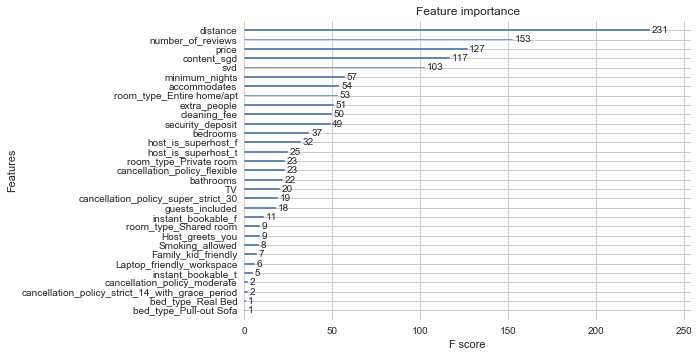

In [469]:
# initialize Our XGBoost model...
hybrid_xgb = xgb.XGBRegressor(silent=False, n_jobs=13, random_state=15, n_estimators=200,learning_rate=0.05,colsample_bytree=0.4603, gamma=0.0468,eval_metric = 'rmse')
train_results, test_results = run_boosting(hybrid_xgb, x_train, y_train, x_test, y_test)

# store the results in models_evaluations dictionaries
models_evaluation_train['hybrid_xgb'] = train_results
models_evaluation_test['hybrid_xgb'] = test_results

xgb.plot_importance(hybrid_xgb)
plt.show()

#### LGB Model

Training the model..
Done. Time taken : 0:00:02.002736

Done 

Evaluating the model with TRAIN data...
Evaluating Test data

TEST DATA
------------------------------
RMSE :  0.4160405986810947
MAPE :  8.297646529379186


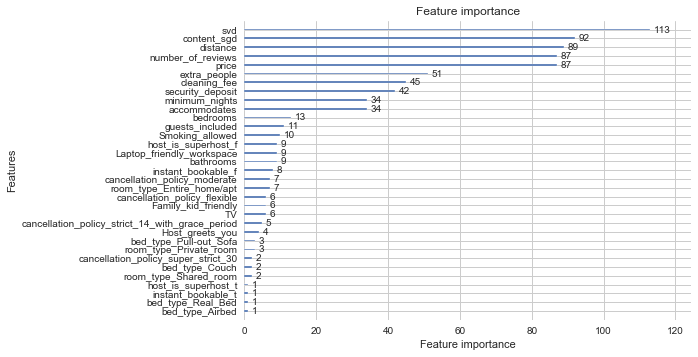

In [470]:
hybrid_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.8, n_estimators=200,eval_metric = 'rmse')
train_results, test_results = run_boosting(hybrid_lgb, x_train, y_train, x_test, y_test)

# store the results in models_evaluations dictionaries
models_evaluation_train['hybrid_lgb'] = train_results
models_evaluation_test['hybrid_lgb'] = test_results

lgb.plot_importance(hybrid_lgb)
plt.show()

### AdaBoost

Training the model..
Done. Time taken : 0:01:47.366249

Done 

Evaluating the model with TRAIN data...
Evaluating Test data

TEST DATA
------------------------------
RMSE :  0.47565969969393
MAPE :  9.322688619932858


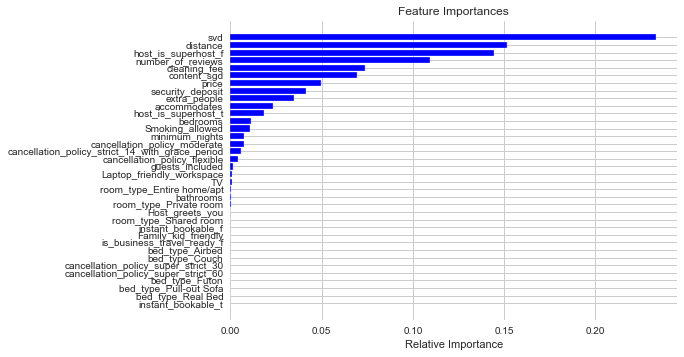

In [471]:
hybrid_AdaBoost = AdaBoostRegressor(n_estimators= 200, random_state=15,learning_rate=0.1,loss = 'square')

train_results, test_results = run_boosting(hybrid_AdaBoost, x_train, y_train, x_test, y_test)

# store the results in models_evaluations dictionaries
models_evaluation_train['hybrid_AdaBoost'] = train_results
models_evaluation_test['hybrid_AdaBoost'] = test_results



features = list(x_train.columns)
importances = hybrid_AdaBoost.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### CatBoost

Training the model..
0:	learn: 1.5689035	total: 62.8ms	remaining: 1.19s
1:	learn: 0.7200376	total: 104ms	remaining: 933ms
2:	learn: 0.4550191	total: 127ms	remaining: 717ms
3:	learn: 0.3964883	total: 164ms	remaining: 654ms
4:	learn: 0.3860132	total: 233ms	remaining: 699ms
5:	learn: 0.3841190	total: 258ms	remaining: 603ms
6:	learn: 0.3834926	total: 286ms	remaining: 530ms
7:	learn: 0.3832830	total: 336ms	remaining: 504ms
8:	learn: 0.3831793	total: 357ms	remaining: 436ms
9:	learn: 0.3831293	total: 377ms	remaining: 377ms
10:	learn: 0.3830406	total: 399ms	remaining: 326ms
11:	learn: 0.3829847	total: 523ms	remaining: 349ms
12:	learn: 0.3829547	total: 556ms	remaining: 299ms
13:	learn: 0.3829397	total: 593ms	remaining: 254ms
14:	learn: 0.3829293	total: 618ms	remaining: 206ms
15:	learn: 0.3829078	total: 718ms	remaining: 180ms
16:	learn: 0.3828901	total: 741ms	remaining: 131ms
17:	learn: 0.3828863	total: 760ms	remaining: 84.4ms
18:	learn: 0.3828622	total: 838ms	remaining: 44.1ms
19:	learn: 0.3828

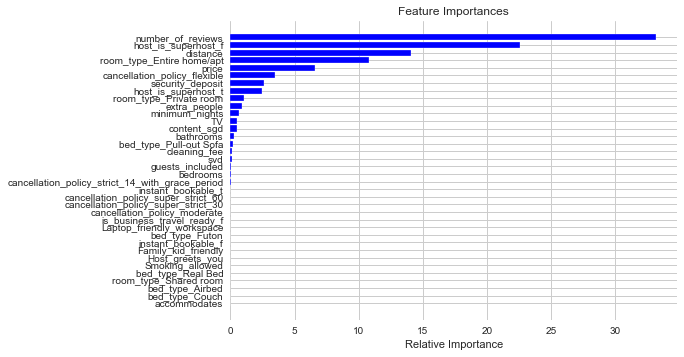

In [472]:
hybrid_CatBoost = CatBoostRegressor(learning_rate=0.6,depth=2,n_estimators=20)

train_results, test_results = run_boosting(hybrid_CatBoost, x_train, y_train, x_test, y_test)

# store the results in models_evaluations dictionaries
models_evaluation_train['hybrid_CatBoost'] = train_results
models_evaluation_test['hybrid_CatBoost'] = test_results

features = list(x_train.columns)
importances = hybrid_CatBoost.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## Comparision between all models

In [448]:
# Saving our TEST_RESULTS into a dataframe so that you don't have to run it again
pd.DataFrame(models_evaluation_test).to_csv(os.path.join(dir_path , 'result/model_evaluation_results.csv'))
models = pd.read_csv(os.path.join(dir_path , 'result/model_evaluation_results.csv'), index_col=0)
models.loc[['rmse','mape']]

,svd,content_sgd,hybrid_xgb,hybrid_lgb,hybrid_AdaBoost,hybrid_CatBoost
rmse,0.4167141932043671,0.434850076922623,0.41386215397580445,0.4160405986810947,0.47565969969393,0.41440293771755043
mape,8.35117408501594,8.442736950441033,8.241416784832227,8.297646529379186,9.322688619932858,8.2498793771266
